# Exploratory Data Analysis

In [1]:
import numpy as np  
import pandas as pd 

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("D:\\Nueva carpeta\\Train_data.csv")
data.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,Target
0,59.0,12.8,3.4,1.3,2.6,51.0,0.2,0.3,50.0,0.7,0.8,78.0,1.1,2.3,3.3,0.5,0.3,0.4,0.5,1
1,31.0,10.7,3.4,1.2,3.3,35.3,0.5,2.1,25.8,0.5,0.9,55.2,0.3,1.1,1.4,0.4,0.3,0.1,0.2,0
2,48.0,9.3,4.5,1.7,3.4,49.7,0.0,0.1,0.0,1.2,1.9,61.5,0.4,0.8,1.2,0.8,0.5,0.4,1.0,0
3,80.0,27.7,11.2,3.5,9.4,37.4,1.3,4.1,32.9,2.8,3.3,85.0,0.8,1.6,2.4,3.9,1.3,0.1,2.2,1
4,58.0,18.4,5.8,1.9,5.3,36.7,0.0,0.1,25.0,1.9,3.1,61.7,0.5,0.7,1.2,1.9,1.1,0.2,1.7,0


In [3]:
data.shape

(1101, 20)

In [4]:
data['Target'].value_counts()

0    551
1    550
Name: Target, dtype: int64

In [5]:
data.isna().sum()

GP         0
MIN        0
PTS        0
FGM        0
FGA        0
FG%        0
3P Made    0
3PA        0
3P%        0
FTM        0
FTA        0
FT%        0
OREB       0
DREB       0
REB        0
AST        0
STL        0
BLK        0
TOV        0
Target     0
dtype: int64

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

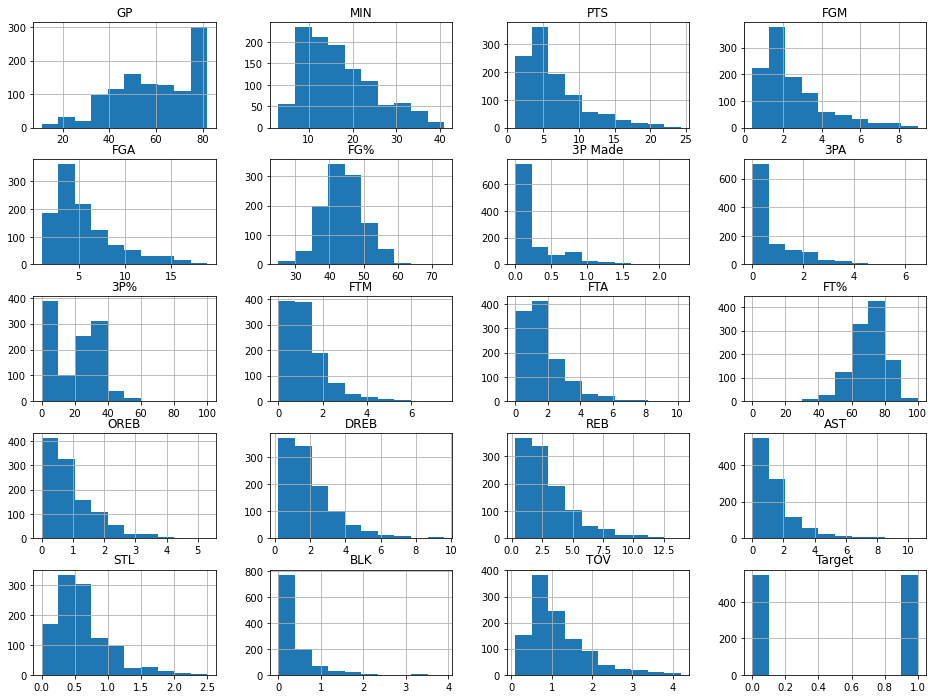

In [7]:
data.hist(bins=10, figsize=(16,12))
plt.show()

<AxesSubplot:>

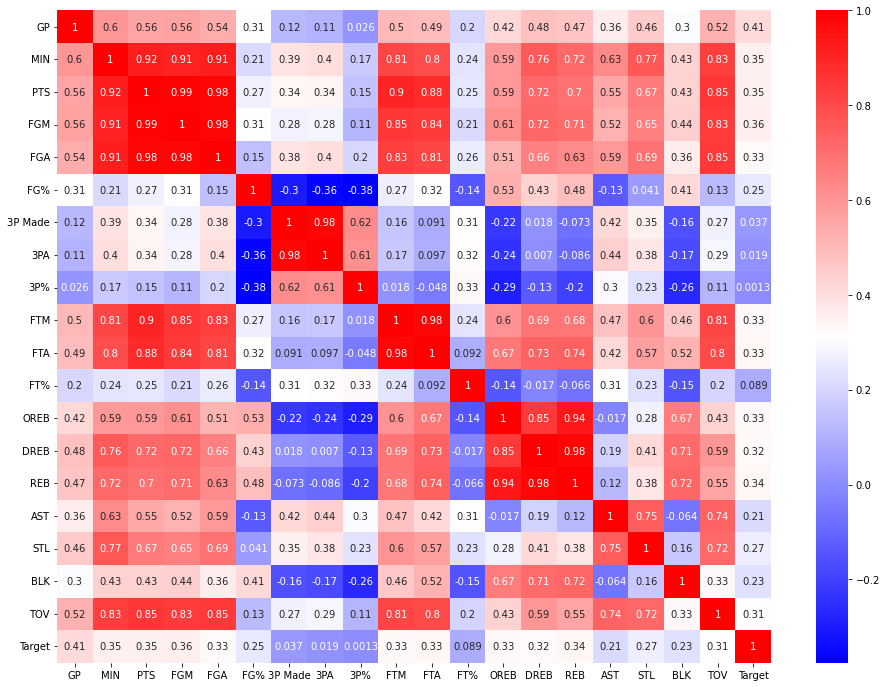

In [8]:
plt.figure(figsize=(16, 12))
sns.heatmap(data.corr(), cmap='bwr', annot=True) # annot = True: to display the correlation value in the graph

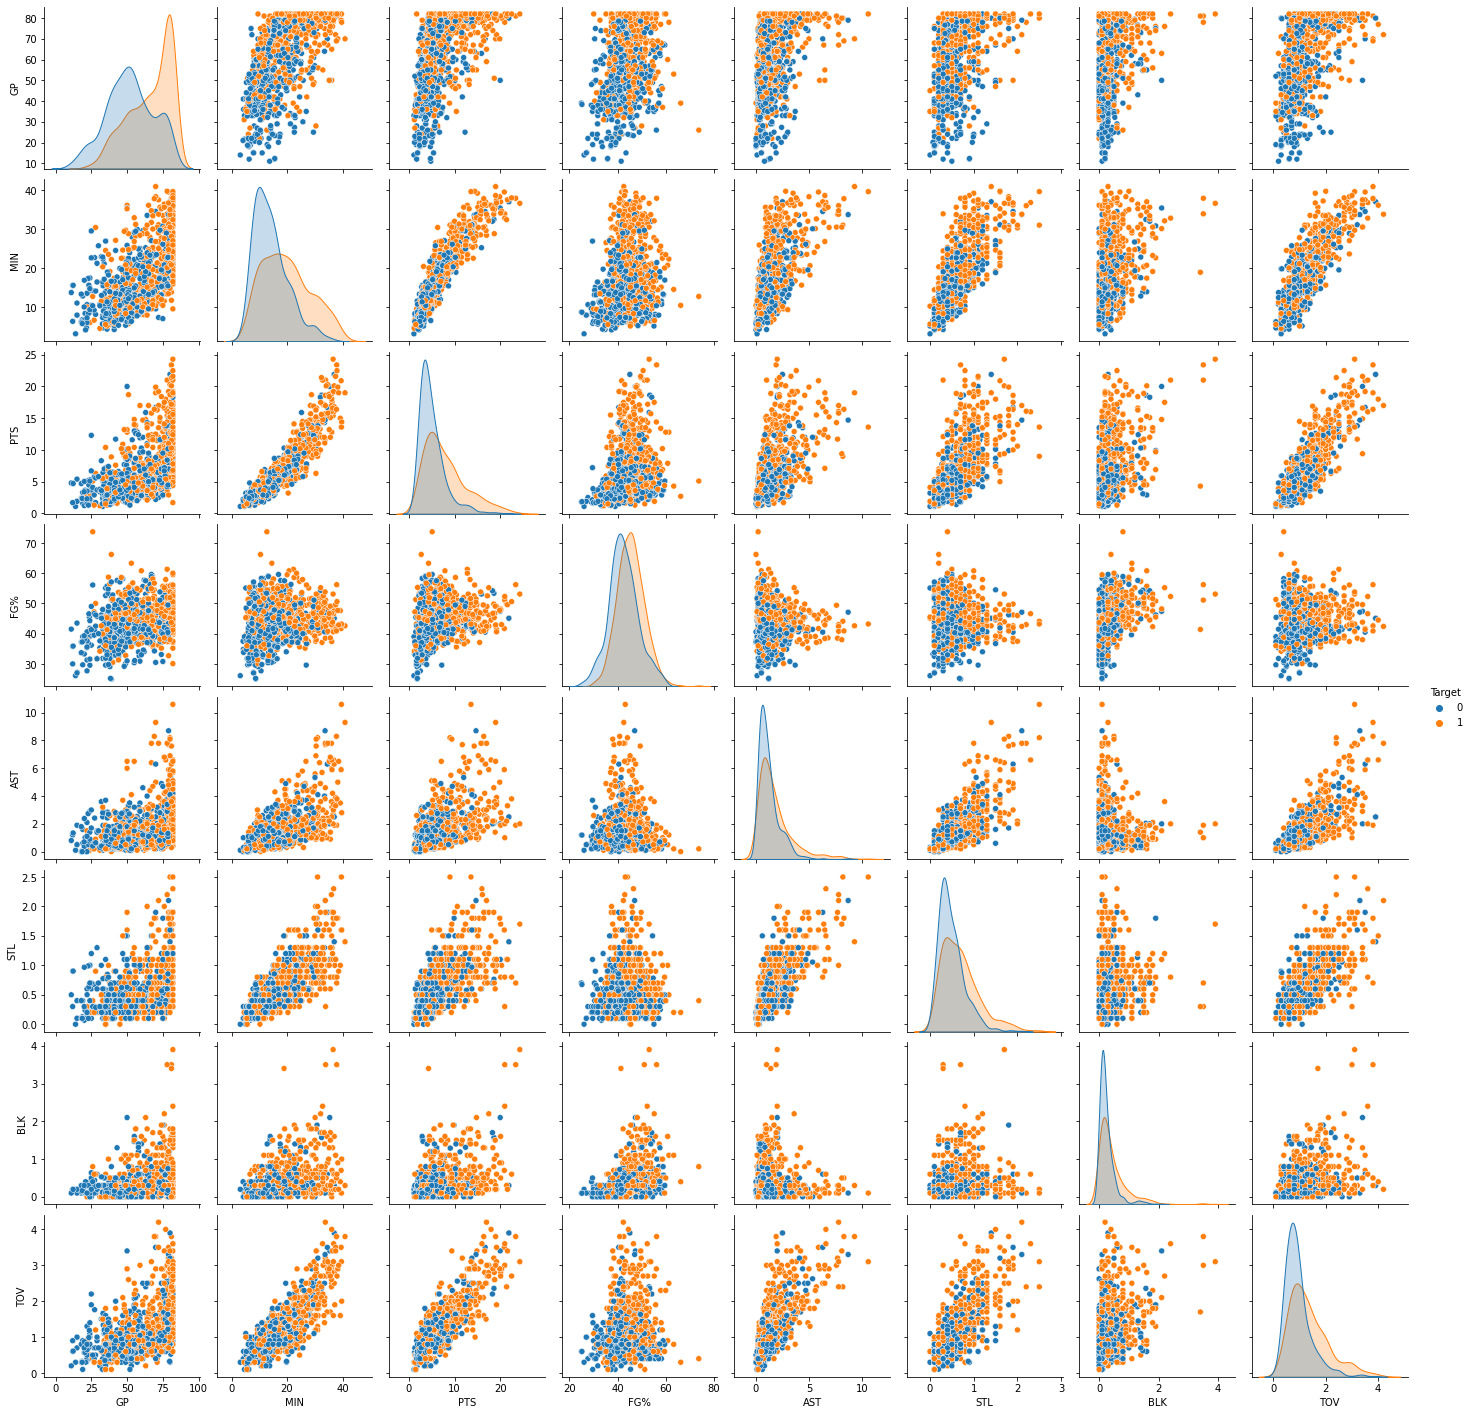

In [9]:
sns.pairplot(data[["GP","MIN","PTS","FG%","AST","STL","BLK","TOV","Target"]],hue="Target")

### New features

I'll use clusters as a feature because there are some position where a player could play and the criterium of succesful is different among positions. I expect that the clusters recognise this patterns and help the algorimths to classified 

In [12]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters = 4).fit(data.drop("Target", axis = 1))

data["cluster"] = clustering.predict(data.drop("Target", axis = 1))

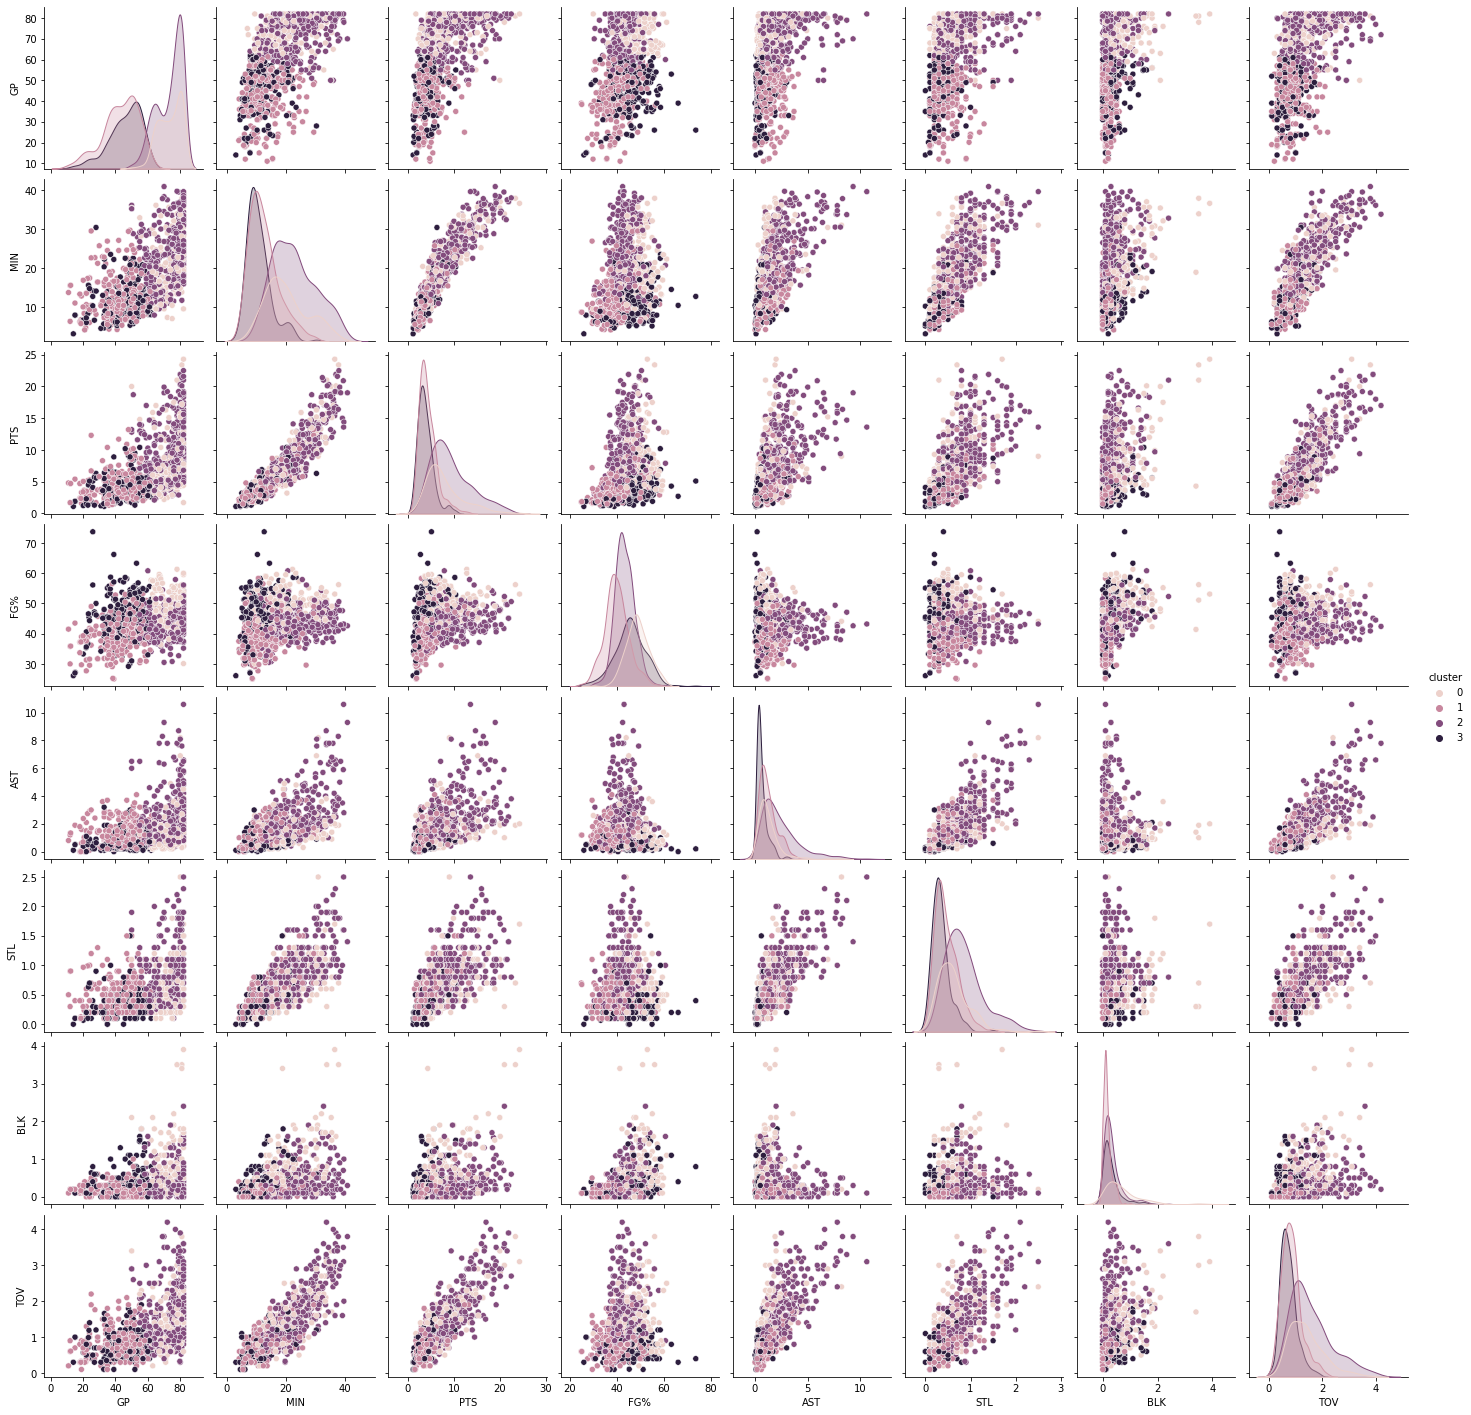

In [13]:
sns.pairplot(data[["GP","MIN","PTS","FG%","AST","STL","BLK","TOV","cluster"]],hue="cluster")

In [14]:
data = pd.get_dummies(data=data, columns=['cluster'])

# Model training

## XGBoost

In [15]:
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

y = data.Target                
X = data.drop('Target', axis=1) 

seed = 8
test_size = 0.10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)


In [67]:
model = XGBClassifier(use_label_encoder=False, eval_metric='error',
                      learning_rate=0.2,gamma=0.25,max_depth=3) # Recall for ensure precision

In [68]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0.25, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [69]:
y_pred_xg = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_xg)
accuracy

0.7027027027027027

In [66]:
metrics.confusion_matrix(y_test, y_pred_xg)

array([[39, 14],
       [19, 39]], dtype=int64)

## Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

y_pred_rf = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf)
accuracy

0.7117117117117117

In [21]:
metrics.confusion_matrix(y_test, y_pred_rf)

array([[41, 12],
       [20, 38]], dtype=int64)

## SVM

In [22]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svm = make_pipeline(StandardScaler(), SVC(kernel="poly",gamma="scale",probability=True))
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_svm)
accuracy

0.7297297297297297

In [23]:
metrics.confusion_matrix(y_test, y_pred_svm)

array([[43, 10],
       [20, 38]], dtype=int64)

## Gradient Boosting

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2,
                                 max_depth=2, random_state=0).fit(X_train, y_train)

y_pred_gbc = gbc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_gbc)
accuracy

0.7387387387387387

In [40]:
metrics.confusion_matrix(y_test, y_pred_gbc)

array([[40, 13],
       [17, 41]], dtype=int64)

# Voting

In [103]:
from sklearn.ensemble import VotingClassifier

clf1 = XGBClassifier(use_label_encoder=False, eval_metric='error',
                      learning_rate=0.3,gamma=0.25,max_depth=6)
clf2 = RandomForestClassifier(n_estimators=100)
clf3 = make_pipeline(StandardScaler(), SVC(kernel="poly",gamma="scale",probability=True))
clf4 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.3,
                                 max_depth=2, random_state=0)

eclf1 = VotingClassifier(estimators=[('xgb', clf1), ('rf', clf2), ('svm', clf3), ('gbc', clf4)], 
                         voting='soft',weights = [2,1,1,1])
eclf1 = eclf1.fit(X_train, y_train)

y_pred_voting = eclf1.predict(X_test)

In [104]:
accuracy = accuracy_score(y_test, y_pred_voting)
accuracy

0.7387387387387387

In [105]:
eclf_total = eclf1.fit(X, y)

y_pred_total = eclf_total.predict(X)

accuracy = accuracy_score(y, y_pred_total)
accuracy

0.9900090826521344

# Prediction

In [106]:
test = pd.read_csv("D:\\Nueva carpeta\\Test_data.csv")

test.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,44.0,13.0,6.6,2.5,5.6,45.3,0.4,1.3,32.7,1.1,1.7,65.3,0.8,0.6,1.4,1.1,0.7,0.2,1.0
1,51.0,9.1,2.7,1.0,2.7,39.0,0.1,0.3,23.5,0.6,0.8,69.8,0.3,0.7,1.0,0.9,0.6,0.1,0.7
2,51.0,15.1,5.7,2.2,5.2,41.2,0.3,0.8,32.5,1.1,1.6,69.1,0.4,1.3,1.7,2.1,0.7,0.0,1.4
3,15.0,7.9,1.9,0.7,2.5,27.0,0.0,0.0,0.0,0.5,0.8,66.7,0.5,1.1,1.5,0.5,0.1,0.1,1.0
4,36.0,14.4,5.8,2.3,5.4,43.1,0.0,0.1,50.0,1.1,1.4,82.0,1.1,1.4,2.4,0.9,0.3,0.2,0.9


In [107]:
test["cluster"] = clustering.predict(test)
test = pd.get_dummies(data=test, columns=['cluster'])

prediction = eclf_total.predict(test)

In [108]:
prediction = pd.DataFrame(prediction, columns=["prediction"])

prediction

,prediction
0,0
1,0
2,0
3,0
4,1
...,...
550,1
551,1
552,1
553,0


In [109]:
prediction.to_csv("D:\\Nueva carpeta\\Submission.csv",index=False)